## Model (No Prescription):

$$\max  \quad R\sum_{j=1}^{N_C}{y_j} -  \sum_{i=1}^{N_S}{[z_iFC_i + c_iVC_i]} + \sum_{i=1}^{N_S}{\sum_{j=1}^{N_C}{s_{ij}T_{ij}}}$$
$$s.t.$$
$$y_j \leq \sum_{i=1}^{N_S}{x_{ij}}  \quad \forall{j}\quad\quad(1)$$
$$y_j \leq \hat{D}_j  \quad \forall{j}\quad\quad(2)$$
$$\sum_{j=1}^{N_C}{x_{i,j}} \leq c_i \quad \forall{i}\quad\quad(3)$$  
$$x_{ij} \leq B_is_{ij} \quad \forall{i} \forall{j}\quad\quad(4)$$
$$c_i \leq B_iz_i \quad \forall{i}\quad\quad(5)$$
<center>$s_{i,j} \leq z_i \quad \forall{i}\forall{j}\quad\quad(6)$

## Inputs:

- $N_S$: Total number of potential suppliers
- $N_C$: Total number of customers
- $FC_i$: Fixed cost for contracting supplier $i$
- $VC_i$: Amount ordered from contracted supplier $i$
- $T_{i,j}$: Distance from supplier $i$ to customer $j$ in miles
- $B_i$: Maximum inventory of supplier $i$
- $D_j$: Demand of county $j$ ---- uncertain
- $R$: revenue per product sold

## Decision Variables:

- $z_i$: Indicates whether supplier $i$ is contracted (= 1 if opened, = 0 otherwise)
- $c_i$: Inventory ordered from supplier $i$
- $s_{ij}$: Indicates whether customer $j$ is supplied by supplier $i$ (= 1 if true, = 0 otherwise)
- $x_{ij}$: Total number of goods shipped from supplier $i$ to customer $j$ 
- $y_{j}$: Total number of goods bought by customer $j$

## Model (Prescription):

$$\max  \quad R\sum_{j=1}^{N_C}{y_{jk}} -  \sum_{i=1}^{N_S}{[z_iFC_i + c_iVC_i]} + \sum_{i=1}^{N_S}{\sum_{j=1}^{N_C}{s_{ijk}t_{ij}}}$$
$$s.t.$$
$$y_{jk} \leq \sum_{i=1}^{N_S}{x_{ijk}}  \quad \forall{j}\quad\quad(1)$$
$$y_{jk} \leq \hat{D}_{jk}  \quad \forall{j}\quad\quad(2)$$
$$\sum_{j=1}^{N_C}{x_{ijk}} \leq c_i \quad \forall{i}\quad\quad(3)$$  
$$x_{ijk} \leq B_is_{ijk} \quad \forall{i} \forall{j}\quad\quad(4)$$
$$c_i \leq B_iz_i \quad \forall{i}\quad\quad(5)$$
<center>$s_{ijk} \leq z_i \quad \forall{i}\forall{j}\quad\quad(6)$

## Inputs:

- $N_S$: Total number of potential suppliers
- $N_C$: Total number of customers
- $FC_i$: Fixed cost for contracting supplier $i$
- $VC_i$: Amount ordered from contracted supplier $i$
- $T_{i,j}$: Distance from supplier $i$ to customer $j$ in miles
- $B_i$: Maximum inventory of supplier $i$
- $\hat{D}_{jk}$: Demand of county $j$ ---- uncertain
- $R$: revenue per product sold

## Decision Variables:

- $z_i$: Indicates whether supplier $i$ is contracted (= 1 if opened, = 0 otherwise)
- $c_i$: Inventory ordered from supplier $i$
- $s_{ijk}$: Indicates whether customer $j$ is supplied by supplier $i$ (= 1 if true, = 0 otherwise)
- $x_{ijk}$: Total number of goods shipped from supplier $i$ to customer $j$ 
- $y_{jk}$: Total number of goods bought by customer $j$

In [90]:
using Distances, JuMP, Gurobi, CSV, DataFrames, Formatting, Plots;
gurobi_env = Gurobi.Env();

Academic license - for non-commercial use only - expires 2022-08-19


In [49]:
alldata_train = CSV.read("data/alldata_train.csv", DataFrame);
alldata_test = CSV.read("data/alldata_test.csv", DataFrame);
supplierInfo = CSV.read("data/supplierInfo.csv", DataFrame)[4:end,:];

## Functions

In [52]:
# function to get test point from test set

function getTestPoint(testSet, WeekNum)
    
    testPoint = filter(row -> row.Week_Num == WeekNum, alldata_test)
    
    sort!(testPoint, :UniqueCustomer)
    
    return testPoint
end    

# function to find distances between test point and suppliers
function getDistances(testPoint, supInfo)
    
    NS = size(supInfo)[1]
    NC = size(testPoint)[1]
    
    distances = zeros(NS, NC);
    for i=1:NS
        for j=1:NC
            distances[i,j] = haversine((supInfo[i,3],supInfo[i,4]), (testPoint[j,2],testPoint[j,3]), 3958.8)
        end
    end
    
    return distances
    
end

getDistances (generic function with 1 method)

## Get Constant Parameters

In [267]:
T = getDistances(test147, supplierInfo)
FC = supplierInfo[:,5].*0
#VC = supplierInfo[:,6]
VC = zeros(17)
VC .= 100
B = supplierInfo[:,end]./100
R = 500 # can change this

500

## Testing Model with Week 147 Demand

In [299]:
# setting parameters - using demand from week147 as a test to see if model works
test148 = getTestPoint(alldata_test, 148)

# model run parameters
D = test148[:,end];

In [300]:
# Optimization Model - No Prescription Yet
function optNoPres(Dem)
    
    NS = size(supplierInfo)[1]
    NC = size(Dem)[1]

    model = Model(with_optimizer(Gurobi.Optimizer,TimeLimit=60, gurobi_env));

    @variable(model, z[i=1:NS], Bin)
    @variable(model, c[i=1:NS]>=0)
    @variable(model, s[i=1:NS,j=1:NC], Bin)
    @variable(model, x[i=1:NS,j=1:NC]>=0)
    @variable(model, y[j=1:NC]>=0)

    @constraint(model, [j=1:NC], y[j] <= sum(x[i,j] for i=1:NS))
    @constraint(model, [j=1:NC], y[j] <= Dem[j])
    @constraint(model, [i=1:NS], sum(x[i,j] for j=1:NC) <= c[i])
    @constraint(model, [i=1:NS,j=1:NC], x[i,j] <= B[i]*s[i,j])
    @constraint(model, [i=1:NS], c[i] <= B[i]*z[i])
    @constraint(model, [i=1:NS,j=1:NC], s[i,j] <= z[i])

    @objective(model, Max, R*sum(y[j] for j=1:NC) - sum(z[i]*FC[i] + c[i]*VC[i] for i=1:NS) - sum(1*s[i,j]*T[i,j] for i=1:NS, j=1:NC))

    set_optimizer_attribute(model, "OutputFlag", 0)
    optimize!(model)
    
    return objective_value(model), value.(c), value.(z), value.(y)
    
end

optNoPres (generic function with 1 method)

In [309]:
# Optimization Model - With Prescription
function optPres(Dem)
    
    NS = size(supplierInfo)[1]
    NC = size(Dem)[1]
    
    # GET K FROM SIZE OF Dem
    if isa(Dem, Vector) == true
        K = 1
    else
        K = size(Dem)[2]
    end
    
    weight = zeros(K)
    weight .= 1/K
    # set weights

    model = Model(with_optimizer(Gurobi.Optimizer,TimeLimit=60, gurobi_env));

    @variable(model, z[i=1:NS], Bin)
    @variable(model, c[i=1:NS]>=0)
    @variable(model, s[i=1:NS,j=1:NC,k=1:K],Bin)
    @variable(model, x[i=1:NS,j=1:NC,k=1:K]>=0)
    @variable(model, y[j=1:NC,k=1:K]>=0)

    @constraint(model, [j=1:NC,k=1:K], y[j,k] <= sum(x[i,j,k] for i=1:NS))
    @constraint(model, [j=1:NC,k=1:K], y[j,k] <= Dem[j,k])
    @constraint(model, [i=1:NS,k=1:K], sum(x[i,j,k] for j=1:NC) <= c[i])
    @constraint(model, [i=1:NS,j=1:NC,k=1:K], x[i,j,k] <= B[i]*s[i,j,k])
    @constraint(model, [i=1:NS], c[i] <= B[i]*z[i])
    @constraint(model, [i=1:NS,j=1:NC,k=1:K], s[i,j,k] <= z[i])

    @objective(model, Max, sum(weight[k]*(R*sum(y[j,k] for j=1:NC) - sum(z[i]*FC[i] + c[i]*VC[i] for i=1:NS) - sum(1*s[i,j,k]*T[i,j] for i=1:NS, j=1:NC)) for k=1:K))

    set_optimizer_attribute(model, "OutputFlag", 0)
    optimize!(model)
    
    return objective_value(model), value.(c), value.(z), value.(y)
    
end

optPres (generic function with 1 method)

In [310]:
est_profit, contracts, supChosen, shipments = optPres(D);
est_profit

5.7035210287009336e7

In [293]:
shipments

765-element Vector{Float64}:
   60.7922712
   34.83167454
   57.15406343
   49.1730045
  168.0637964
   69.8277922
  505.7504371
   23.16940208
  262.6561407
   16.9355834
  204.4297181
  110.9077882
   83.90416051
    ⋮
  163.0887855
   61.30806777
   94.57850117
 1090.0
   44.29603032
   64.72625758
   55.93145998
   50.73774365
   45.27315661
   42.9962297
  324.2259966
  574.3403494

In [283]:
custMet = findall(x->x>0.01, shipments);
contrSup = findall(x->x>0.01, contracts);
notContrSup = findall(x->x<0.01, contracts);

println("Cost of Suppliers: \$", sum(supChosen.*FC + contracts.*VC))
println("- Contract Cost: \$", sum(supChosen.*FC))
println("- Order Cost: \$", sum(contracts.*VC))
println("")
println("Number of suppliers: ", sum(supChosen))
println("")
println("Number of customers shipped: ", size(custMet)[1])

Cost of Suppliers: $1.42697045259991e7
- Contract Cost: $0.0
- Order Cost: $1.42697045259991e7

Number of suppliers: 17.0

Number of customers shipped: 765


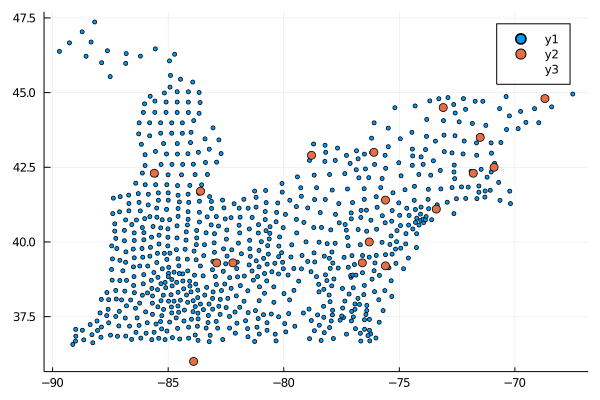

In [284]:
scatter(test147[custMet,3],test147[custMet,2], markersize =3,format=:png)
scatter!(supplierInfo[contrSup,4], supplierInfo[contrSup,3],markersize=5,format=:png)
scatter!(supplierInfo[notContrSup,4], supplierInfo[notContrSup,3],markersize=5,format=:png)

In [288]:
# Optimization Model - No Prescription Yet
function checkReality(contr, trueDem)
    
    NS = size(supplierInfo)[1]
    NC = size(trueDem)[1]

    model = Model(with_optimizer(Gurobi.Optimizer,TimeLimit=60, gurobi_env));

    @variable(model, z[i=1:NS], Bin)
    @variable(model, c[i=1:NS]>=0)
    @variable(model, k[i=1:NS,j=1:NC], Bin)
    @variable(model, x[i=1:NS,j=1:NC]>=0)
    @variable(model, y[j=1:NC]>=0)

    @constraint(model, [i=1:NS], c[i] == contr[i])
    
    @constraint(model, [j=1:NC], y[j] <= sum(x[i,j] for i=1:NS))
    @constraint(model, [j=1:NC], y[j] <= trueDem[j])
    @constraint(model, [i=1:NS], sum(x[i,j] for j=1:NC) <= c[i])
    @constraint(model, [i=1:NS,j=1:NC], x[i,j] <= B[i]*k[i,j])
    @constraint(model, [i=1:NS], c[i] <= B[i]*z[i])
    @constraint(model, [i=1:NS,j=1:NC], k[i,j] <= z[i])

    @objective(model, Max, R*sum(y[j] for j=1:NC) - sum(z[i]*FC[i] + c[i]*VC[i] for i=1:NS) - sum(1*k[i,j]*T[i,j] for i=1:NS, j=1:NC))

    set_optimizer_attribute(model, "OutputFlag", 0)
    optimize!(model)
    
    return objective_value(model), value.(y)
    
end

checkReality (generic function with 1 method)

In [301]:
## ASSUMING 149 is true demand

# setting parameters - using demand from week147 as a test to see if model works
test149 = getTestPoint(alldata_test, 149)

# model run parameters
true_D = test149[:,end];

In [303]:
# check how we did using 148 as predicted demand
simpleEst_true_profit, simpleEst_true_shipments = checkReality(contracts, true_D);
simpleEst_true_profit

5.7063249310359776e7

In [304]:
# oracle profit
est_profit, contracts, supChosen, shipments = optNoPres(true_D);
est_profit

6.681483539124811e7

In [320]:
# make D = 148:149 and hopefully it gives better true profit
D148 = D
D150 = true_D

testpresDem = Matrix([D148';D149']')

pres_est_profit, pres_contracts, pres_supChosen, pres_shipments = optPres(testpresDem);
pres_est_profit

6.070403982862243e7

In [321]:
# check how we did using 148 and 149 in prescription
pres_true_profit, pres_true_shipments = checkReality(pres_contracts, true_D);
pres_true_profit

6.681616992763527e7

In [ ]:
# to do tmw - before knn

# get two random test days - make matrix and try pres
# average those two days - try that and hopefully its less than above